Elements based on the notebooks by J.R. Johansson (robert@riken.jp) from [http://github.com/jrjohansson/scientific-python-lectures](http://github.com/jrjohansson/scientific-python-lectures).

# Array Programming

In computer science, **array programming languages** (also known as vector or multidimensional languages) generalize operations on scalars to apply transparently to vectors, matrices, and higher-dimensional arrays.

The basis behind array programming and thinking is to find and exploit the properties of data where individual elements are similar or adjacent. Unlike object orientation which implicitly breaks down data to its constituent parts (or scalar quantities), array orientation looks to group data and apply a uniform handling.

-- https://en.wikipedia.org/wiki/Array_programming

# Pros & Cons

Advantages:
1. Array programming primitives concisely express broad ideas about data manipulation.
1. Array programming expressions parallelize naturally (to multi-core or multi-\* systems, including GPUs)
1. Array programming can hide the slowness of interpreted languages like Python

Disadvantages:
1. It's not the most natural way to think about all problems
1. It's easy to write code that takes up a lot of memory (by accident)

# Array Programming in Python: Numpy

NumPy is an extension to the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large library of high-level mathematical functions to operate on these arrays -- http://en.wikipedia.org/wiki/NumPy.

You've already learned about numpy in ASTR300; ***the goal here is to deepen your understanding of the underlying concepts.***

## Why `numpy`?

Performance and ease of use.

The `numpy` package (module) is used in almost all numerical computation using Python. It is a package that provide high-performance vector, matrix and higher-dimensional data structures for Python. It is implemented in C and Fortran so when calculations are vectorized (formulated with vectors and matrices), performance is very good. 

To use `numpy` need to import the module it using of example:

In [2]:
import numpy as np

In the `numpy` package the terminology used for vectors, matrices and higher-dimensional data sets is *array*. 



## Performance

Compared to C++ or FORTRAN, Python is *very* slow when operating on large lists (arrays) of data, using for loops.

In [3]:
import numpy as np

N = 1000
a = np.arange(N)
b = np.arange(N)
c = np.empty(N)

In [4]:
%%timeit
for i in range(N):
    c[i] = a[i] * b[i]

336 µs ± 5.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Doing the same operation with numpy makes it run orders of magnitude faster

In [5]:
%timeit c = a*b

863 ns ± 27.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


# Why is this the case?

Because Python is an interpreted language, _and_ because the Python interpreter has no performance optimizations that some other interpreted languages have (Java (and JVM-based languages), Julia).


# Understanding Numpy

How can `numpy` be so much faster? How does it work "under the hood"?

At its core is a multi-dimensional array class, named `ndarray`. Try this:

In [6]:
type(a)

numpy.ndarray

This class overloads all classical arithmetric operators (+, -, /, etc.).

### Example of Operator Overloading

In [7]:
class Mod5Number:
    def __init__(self, x=0):
        self.value = x.value if isinstance(x, Mod5Number) else x % 5
    
    def __add__(self, y):
        y = Mod5Number(y)
        self.value += y.value
        self.value %= 5
        return self

    def __sub__(self, y):
        y = Mod5Number(y)
        self.value -= y.value
        self.value %= 5
        return self
        
    def __repr__(self):
        return str('Mod5Number({})'.format(self.value))

x = Mod5Number(2)
y = Mod5Number(4)
x + y 

Mod5Number(1)

In [8]:
x = Mod5Number(5)
x

Mod5Number(0)

So when you type:

In [9]:
c = a + b

the `+` in `a + b` is converted to a call to `ndarray.__add__` function, and that function is implemented in `C`, compiled, and ___very fast___.

The same is true of nearly all core numpy functions.

## Where Does the Speedup Come From?

1. With one call -- `a + b` -- we've commanded the library to do a lot of work and return with the result. We don't "micromanage" _how_ the work gets done, like we did when writing for loops (\*, \**).
2. The actual work is done in compiled code, making it as fast as a solution written in C or C++.
3. There's enough work to be done that it -- the work -- dominates the run time, rather than the time spent in Python.

(\*) It's the same in real life: imagine getting _anything_ done if your boss (literally) managed your every move (*"step here... now move there... now raise your right hand..."*)

(\*\*) It also allows for many interesting optimizations -- for example, have the multiple cores on your machine do the addition in parallel (actually implemented in `numpy`).

## The Zen of Array Programming

1. Care not about a single object; care about the set, the array.
1. Think not of your problem as an array of transformations, but transformations of the arrays.
1. Decompose your problem into primitive transformations available in numpy (and/or pandas; more later).
1. Mask the slowness of Python by working with many elements at a time (stars, galaxies, measurements, ...)

## `ndarray` basics: creation, shape, type

In [10]:
# a vector: the argument to the array function is a Python list
v = np.array([1,2,3,4])

v

array([1, 2, 3, 4])

In [11]:
# a matrix: the argument to the array function is a nested Python list
M = np.array([[1., 2.], [3., 4.]])

M

array([[1., 2.],
       [3., 4.]])

The `v` and `M` objects are both of the type `ndarray` that the `numpy` module provides.

In [12]:
type(v), type(M)

(numpy.ndarray, numpy.ndarray)

even though their dimensions (shapes) differ.

The difference between the `v` and `M` arrays is only their shapes. We can get information about the shape of an array by using the `ndarray.shape` property.

In [13]:
v.shape

(4,)

In [14]:
M.shape

(2, 2)

The number of elements in the array is available through the `ndarray.size` property:

In [15]:
v.size

4

Using the `dtype` (data type) property of an `ndarray`, we can see what type the data of an array has:

In [16]:
M.dtype

dtype('float64')

We get an error if we try to assign a value of the wrong type to an element in a numpy array:

In [17]:
M[0,0] = "hello"

ValueError: could not convert string to float: 'hello'

If we want, we can explicitly define the type of the array data when we create it, using the `dtype` keyword argument: 

In [18]:
M = np.array([[1, 2], [3, 4]], dtype=float)

M

array([[1., 2.],
       [3., 4.]])

Common type that can be used with `dtype` are: `int`, `float`, `complex`, `bool`, `object`, etc.

We can also explicitly define the bit size of the data types, for example: `int64`, `int16`, `float128`, `complex128`.

## An aside: Why explicit types? Speed.


E.g., Python's lists allow you to mix types:
```
x = [1, "Two", 3.0]
```
This is convenient but comes with a performance cost: in memory, it must be implemented as a list, rather than a compact array.

### Creating numpy arrays: array-generating functions

For larger arrays it is impractical to initialize the data manually, using explicit python lists. Instead we can use one of the many functions in `numpy` that generates arrays of different forms. Some of the more common are:

#### arange

In [19]:
# create a range

x = np.arange(0, 10, 1) # arguments: start, stop, step

x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### An aside: 
With Python 3 to address issues associated with large vectors python returns an "iterator" rather than the list 

In [20]:
x = range(0, 10, 1)
print(x)
print(list(x))

range(0, 10)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


#### linspace and logspace

In [21]:
# using linspace, both end points ARE included
np.linspace(0, 10, 25)

array([ 0.        ,  0.41666667,  0.83333333,  1.25      ,  1.66666667,
        2.08333333,  2.5       ,  2.91666667,  3.33333333,  3.75      ,
        4.16666667,  4.58333333,  5.        ,  5.41666667,  5.83333333,
        6.25      ,  6.66666667,  7.08333333,  7.5       ,  7.91666667,
        8.33333333,  8.75      ,  9.16666667,  9.58333333, 10.        ])

In [22]:
np.logspace(0, 10, 10, base=np.e)

array([1.00000000e+00, 3.03773178e+00, 9.22781435e+00, 2.80316249e+01,
       8.51525577e+01, 2.58670631e+02, 7.85771994e+02, 2.38696456e+03,
       7.25095809e+03, 2.20264658e+04])

#### zeros and ones

In [23]:
np.zeros((3,3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [24]:
np.ones((3,3))

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

#### Creating arrays by reading from files

In [25]:
!head -n 3 td_adj.dat

1800  1  1    -6.1    -6.1    -6.1 1
1800  1  2   -15.4   -15.4   -15.4 1
1800  1  3   -15.0   -15.0   -15.0 1


In [26]:
data = np.genfromtxt('td_adj.dat')
data[:2]

array([[ 1.80e+03,  1.00e+00,  1.00e+00, -6.10e+00, -6.10e+00, -6.10e+00,
         1.00e+00],
       [ 1.80e+03,  1.00e+00,  2.00e+00, -1.54e+01, -1.54e+01, -1.54e+01,
         1.00e+00]])

... and our other well known functions, such as read_csv, or Pandas functions, implement the same concept: creating an array from somewhere (rather than thinking in terms of individual elements).


## Manipulating (transforming) arrays

### Retrieving array subsets: Indexing

You're already familiar with basic indexing, returning a single element:

In [27]:
# v is a vector, and has only one dimension, taking one index
v[0]

1

In [28]:
# M is a matrix, or a 2 dimensional array, taking two indices 
M[1,1]

4.0

If we omit an index of a multidimensional array it returns the whole row (or, in general, a N-1 dimensional array) 

In [ ]:
import numpy as np
M = np.random.rand(30,30)
M[0]

In [32]:
M = np.random.rand(3,3)
M

array([[0.87551818, 0.75709288, 0.90229146],
       [0.7300774 , 0.0431338 , 0.85326575],
       [0.7102339 , 0.93278069, 0.67731851]])

In [33]:
M[1]

array([0.7300774 , 0.0431338 , 0.85326575])

You can be more explicit by using `:` in place of a number: 

In [34]:
M[1,:] # row 1

array([0.7300774 , 0.0431338 , 0.85326575])

In [35]:
M[:,1] # column 1

array([0.75709288, 0.0431338 , 0.93278069])

### An Aside: Slices

There's (almost) nothing magical about the `:` character in the example above.

It's [syntactic sugar](https://en.wikipedia.org/wiki/Syntactic_sugar) for creation of an object of class `slice`.

In [ ]:
slice?

and is equivalent to:

In [ ]:
M[slice(None), 1]

and also to:

In [ ]:
M.__getitem__( (slice(None), 1) )

We can assign new values to elements in an array using indexing:

In [ ]:
M[0,0] = 1

In [ ]:
M

In [ ]:
# also works for rows and columns
M[1,:] = 0
M[:,2] = -1

### An Aside: `[]` maps to `__getitem__` and `__setitem__`

The above is equivalent to:

In [ ]:
M.__setitem__((slice(None),2), -1)
M

(and again an example of a good use of syntactic sugar!)

### Slicing

What we've seen is one particular usage of _index slicing_.

Index slicing is the technical name for the syntax `M[lower:upper:step]` to extract part of an array:

In [37]:
A = np.array([1,2,3,4,5])
A

array([1, 2, 3, 4, 5])

In [38]:
A[1:3]

array([2, 3])

Array slices are *mutable*: if they are assigned a new value the original array from which the slice was extracted is modified:

In [40]:
A[1:3] = [-2,-3]
A


array([1, 7, 7, 4, 5])

We can omit any of the three parameters in `M[lower:upper:step]`:

In [ ]:
A[::] # lower, upper, step all take the default values

In [ ]:
A[::2] # step is 2, lower and upper defaults to the beginning and end of the array

In [ ]:
A[:3] # first three elements

In [ ]:
A[3:] # elements from index 3

Negative indices counts from the end of the array (positive index from the beginning):

In [ ]:
A = np.array([1,2,3,4,5])

In [ ]:
A[-1] # the last element in the array

In [ ]:
A[-3:] # the last three elements

Index slicing works exactly the same way for multidimensional arrays:

In [ ]:
A = np.array([[n+m*10 for n in range(5)] for m in range(5)])

A

In [ ]:
# a block from the original array
A[1:4, 1:4]

In [ ]:
# strides
A[::2, ::2]

### And a reminder that this is all sugar for...



In [ ]:
A.__getitem__((slice(None, None, 2), slice(None, None, 2)))

## Copy and "deep copy"

To achieve high performance, assignments in Python usually do not copy the underlaying objects. This is important for example when objects are passed between functions, to avoid an excessive amount of memory copying when it is not necessary (technical term: pass by reference). 

In [ ]:
A = np.array([[1, 2], [3, 4]])

A

In [ ]:
# now B is referring to the same array data as A 
B = A 

In [ ]:
# changing B affects A
B[0,0] = 10

B

In [ ]:
A

If we want to avoid this behavior, so that when we get a new completely independent object `B` copied from `A`, then we need to do a so-called "deep copy" using the function `copy`:

In [ ]:
B = np.copy(A)

In [ ]:
# now, if we modify B, A is not affected
B[0,0] = -5

B

In [ ]:
A

### An Aside: The `B = 42` problem

What if I wanted to set all elements of B to a specific value (say, 42)?

This:
```
B = 42
```
will set B itself to be equal to 42 (and not be a matrix where each element is 42).

The solution:
```
B[:] = 42
```
.

### Fancy indexing


(qouting JDvP): Fancy indexing is conceptually simple: it means passing an array of indices to access multiple array elements at once:

In [ ]:
A = np.array([[n+m*10 for n in range(5)] for m in range(5)])

A

In [ ]:
row_indices = [1, 2, 3]
A[row_indices]

In [ ]:
col_indices = [1, 2, -1] # remember, index -1 means the last element
A[row_indices, col_indices]

### An Aside: How Does This Work?

There's nothing magical about indexing using a list:

1. `A[row_indices, col_indices]` is transformed to `A.__getitem__((row_indices, col_indices))`
2. The implementation of `ndarray.__getitem__` checks if the indices that were passed to it are numbers, slices, or (in this case) lists/arrays of integers
3. If they're lists or arrays of integers, selects the apropriate rows/columns and returns those (actually, returns the _view_ of those).

### Indexing with masks

We can also index using "masks": if the index is a list or array of with data type `bool`, then an element is selected depending on the value of the index at the position each element: 

In [ ]:
B = np.arange(5)
B

In [ ]:
row_mask = np.array([True, False, True, False, False])
B[row_mask]

In [ ]:
# same thing
row_mask = np.array([1,0,1,0,0], dtype=bool)
B[row_mask]

This feature is very useful to conditionally select elements from an array, using for example comparison operators:

In [ ]:
x = np.arange(0, 10, 0.5)
x

In [46]:
mask = (5 < x) & (x < 7.5)

mask

array([False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
       False, False])

In [44]:
x[mask]

array([5.5, 6. , 6.5, 7. ])

In [45]:
x[(5 < x) & (x < 7.5)]

array([5.5, 6. , 6.5, 7. ])

### An Aside: What just happened here?

The expression
```
mask = (5 < x) & (x < 7.5)
```
is internally translated to calls to special class operator methods:
```
x.__gt__(5).__and__( (x.__lt__(7.5)))
```
and `ndarray`'s comparison methods are written to return an `narray` of `bool` (True/False).

The operator `&` is _bitwise_ `and` ([there are also bitwise or, not, and various shift operators](https://wiki.python.org/moin/BitwiseOperators)). It is a trick to work around the issue that _logical_ `and` (and or, not, etc.) cannot be overloaded in Python. Note, however, that their [precedence](https://docs.python.org/3/reference/expressions.html#operator-precedence) is much lower than that of their logical siblings; that's why we need the parenteses for the above expression to work.

## Getting Comfortable with Fancy Indexing

Fancy indexing (with Numpy as well as other libraries) forms the basis of data analysis with Python: they allow us to extract subsets of input datasets that satisfy one or more particular conditions.

N.b.: note the wiff of array (and functional!) programming way of thinking ("_transforming an input to output dataset_...").

## Testing Arrays

When using arrays in conditions in for example `if` statements and other boolean expressions, one need to use one of `any` or `all`, which requires that any or all elements in the array evaluates to `True`:

In [ ]:
M

In [ ]:
if (M > 5).any():
    print("at least one element in M is larger than 5")
else:
    print("no element in M is larger than 5")

In [ ]:
if (M > 5).all():
    print("all elements in M are larger than 5")
else:
    print("all elements in M are not larger than 5")

### Putting it all together: simple data analysis with numpy

We can analyze data using indexing, fancy indexing, and the other methods of extracting data from an array (described above).

In the directory, I have a small dataset of temperatures measured in Stockholm, Sweden, since 1800:

In [47]:
!head -n 3 td_adj.dat

1800  1  1    -6.1    -6.1    -6.1 1
1800  1  2   -15.4   -15.4   -15.4 1
1800  1  3   -15.0   -15.0   -15.0 1


In [ ]:
data = np.genfromtxt('td_adj.dat')
data[:2]

The dataformat is: year, month, day, daily average temperature, low, high, location.

If we are interested in the average temperature only in a particular month, say February, then we can create an index mask and use the select out only the data for that month using:

In [ ]:
np.unique(data[:,1]) # the month column takes values from 1 to 12

In [ ]:
mask_feb = data[:,1] == 2

The array mask_feb is set to 'True' at locations where the 1st column in data equals 2:

In [ ]:
data[mask_feb][:,1]

In [ ]:
# the temperature data is in column 3
np.mean(data[mask_feb,3])

## Exercise
With these tools we have very powerful data processing capabilities at our disposal. For example, to extract the average monthly average temperatures for each month of the year only takes a few lines of code: 

But we could still make this nicer...

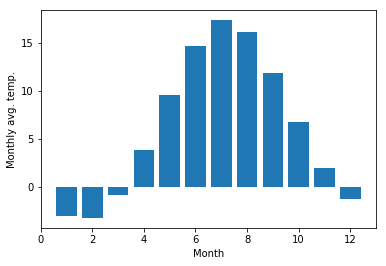

In [73]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(data, columns=["year","month","day","temp","tmin", "tmin2", "flag"])
g = df.groupby(by="month")
fig, ax = plt.subplots()
ax.bar(g.groups.keys(), g.temp.mean())
ax.set_xlabel("Month")
ax.set_ylabel("Monthly avg. temp.");

## The concepts to remember

* **Array programming**: Your Python code will be significantly faster (and sometimes cleaner) if you work with arrays. Think of your work as a sequence of operations (transformations) on arrays. Then think how to decompose your problem to a sequence of array transformations, rather than looping over and transforming individual elements.


* **Array programming in Python: Numpy**: Numpy implements basic array programming in Python and comes with a [large library](https://docs.scipy.org/doc/numpy/reference/index.html) of functions that operate on arrays. Numpy has defined the basic conventions for operations like indexing (fancy indexing, masking, etc.), that virtually all other Python libraries follow.


* **No magic here**: There's no special magic here -- numpy is a Python library, just like any other. You could code up something similar yourselves!

## Further Reading

* Chapters 2 through 9 of Jake VanderPlas' [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/02.02-the-basics-of-numpy-arrays.html)